## Folded Stratigraphy with `curlew`

Using a simple folded stratigraphy, this notebook explores the different kinds of loss functions, and the importance of length scales implemented within `curlew`. Section 4.1 of the paper corresponds to this notebook.

In [6]:
# Import the necessary libraries
import curlew
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

# Optional colormaps (For a prettier look!)
import cmasher as cmr

# Change this to "cuda" if you have CUDA cores!
curlew.device = 'cpu'
curlew.dtype = torch.float32

In [ ]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../Utils/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-2, 2]

# Curlew colormap
import matplotlib.colors as mcolors

# Define the colors extracted manually from the provided logo image
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)

# Random seed
random.seed(42)

In [8]:
# curlew.geometry allows us to define grids for model evaluation
from curlew.geometry import grid
from curlew.visualise import plotDrill, plotConstraints

# Let us define a domain and a grid within the domain
dims = (1500,700)
grid_obj = grid(dims, step=(1,1), center=(dims[0]/2,dims[1]/2), sampleArgs={"poissonDisk": (100, 4096, 404)})
gxy = grid_obj.coords()

# We also define seed points for defining isosurfaces (contacts)
nlayers = 7
sy = np.linspace(0, dims[1] * 0.8, nlayers)
sx = [dims[0]/2 for s in sy]
sxy = np.array([sx,sy]).T

### Let's build a synthetic model!

We will use the analytic implicit fields defined `curlew.fields.analytical`. The sub-module is a work-in-progress set of functions to generate implicit scalar fields with predefined analytical equations.

In [9]:
# The necessary sub-modules
from curlew import GeoModel
from curlew.geology import strati, fold
from curlew.fields.analytical import ALF
from curlew.visualise import plot2D

In [10]:
# Stratigraphic field
s0 = strati('s0', # The name of the scalar field
            C=ALF('f0', input_dim=2,
                  origin=np.array([0, 0]),
                  gradient=np.array([0.0, 0.1])
                 ) # The analytic field defining the layer-cake stratigraphy
           )

# Define units (isosurfaces) in this field
for i,s in enumerate(sxy):
    s0.addIsosurface("S%d"%(i+1), seed=s)

In [11]:
# Define the fold
s1 = fold('s1', origin=np.array([0,0]),  extension=np.array([0.1,0.9]),  
            compression=np.array([0.9,-0.1]), wavelength=1500,  amplitude=100, sharpness=0.6 )
s2 = fold('s2', origin=np.array([12000,0]), extension=np.array([0.2,0.8]), 
            compression=np.array([0.8,-0.2]), wavelength=12000,  amplitude=200, sharpness=0.0 )

# Create a GeoModel object!
analytical_M = GeoModel([s0, s1, s2])

In [12]:
# To mimic reality, let us generate a group of synthetic boreholes
holes_ = [((200,700),(400,100)), #(start-xy, end_xy)
         ((200,700),(0,0)),
         ((500,700),(600,100)),
         ((500,700),(200,100)),
         ((800,700),(700,50)),
         ((800,700),(980,10))]

# Use the GeoModel.drill utility to generate holes
holes = [analytical_M.drill(start, end, step=2) for start, end in holes_]

In [13]:
# Sample Constraints
ss = 2 # subsampling rate
gp = np.vstack( [h['contacts']['pos'] for h in holes] )[1::ss] # gradient constraints
gv = np.vstack( [h['contacts']['ori'] for h in holes] )[1::ss]
vp = np.vstack( [h['contacts']['pos'] for h in holes] )[1::ss] # value constraints
vv = np.hstack( [h['contacts']['scalar'] for h in holes] )[1::ss]

# build equality constraints using contacts
for hole in holes:
    for pos,classID in zip( hole['pos'], hole['classID']):
        n = hole['className'][classID]

# group points into layers (stratigraphic classes)
layers = {}
eq = {} # also store "equality constraints" (interfaces)
for hole in holes:

    # all observations
    for pos,classID in zip( hole['pos'], hole['classID']):
        n = hole['className'][classID]
        layers[n] = layers.get(n, []) + [pos]
    
    # contacts only
    for pos,classID in zip( hole['contacts']['pos'], hole['contacts']['classID']):
        n = hole['className'][classID-1]
        eq[n] = eq.get(n, []) + [pos] 

# use these classes to build inequality constraints
eq = [ (np.vstack( v ), np.vstack( v ), '=') for v in eq.values() ] # these are easy

# build other inequalities
iq = []
for i,n in enumerate(hole['className'][1:]): # n.b. these are ordered from bottom to top
    lhs = [layers[under] for under in hole['className'][0:(i+1)] if under in layers]
    rhs = [layers[over] for over in hole['className'][(i+1):] if over in layers]
    if (len(lhs) > 0) and (len(rhs) > 0):
        #print([under for under in hole['className'][0:(i+1)]], "<", [over for over in hole['className'][(i+1):]])
        iq.append( (np.vstack(lhs), np.vstack(rhs), "<"))

In [14]:
# Build a CSet object
from curlew import CSet
C = CSet(vp=vp, # value constraint positions
         vv=vv, # value constraint values (best keep these quite small)
         gp=gp, # gradient constraint positions
         gv=gv, # gradient constraint values
         gop=gp, # gradient orientation positions
         gov=gv,  # gradient orientation values
         iq=(1024, eq + iq)) # inequality constraints (nsamples, constraints)

# define random sampling for global constraints
grid_obj.sampleArgs = dict(N=4096) # define how many random samples to select during training
C.grid = grid_obj
C.delta = 200 # numerical differentiation step used (in each axis)

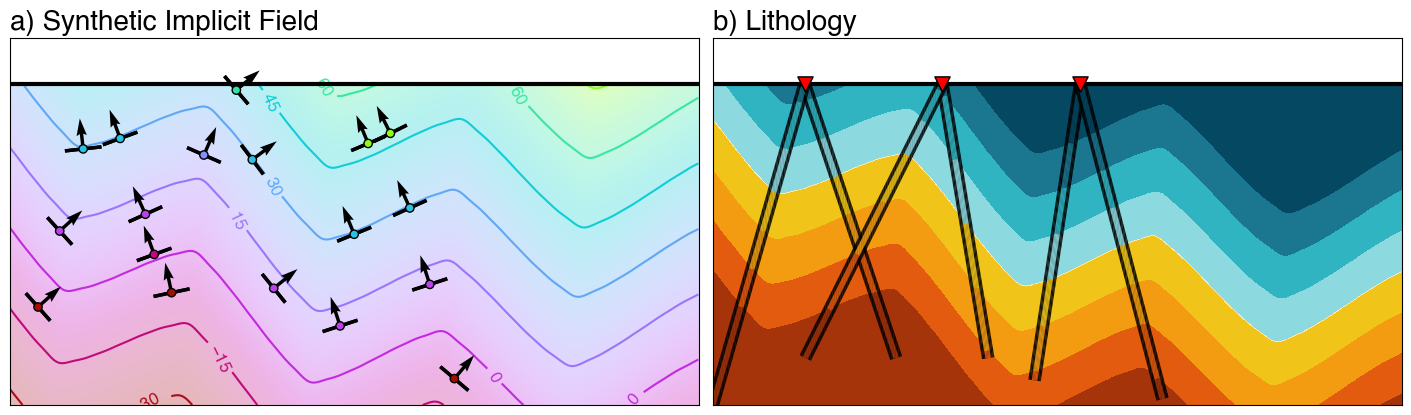

In [15]:
# Plot the model!
fig,ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True, layout="constrained")
pred = analytical_M.predict(gxy)
cid, labels = analytical_M.classify(gxy, return_vals=False)
classes = np.hstack([ h['classID'] for h in holes ]) # limit to classes in drillholes
vmn=np.min(classes)
vmx=np.max(classes)

# Define colormaps
sfield_cm = cmr.neon
colormap = curlew_cmap

# Plot the scalar field and the constraints
plot2D(pred[:, 0], grid_obj, ax=ax[0], cmap=sfield_cm)
plotConstraints(ax[0], C, ll=1.2, lw=0.005, scale=0.015, ac="k", vmn=None, vmx=vmx, cmap=sfield_cm)
# Plot the stratigraphy
plot2D(cid[:, 0], grid_obj, ax=ax[1],  levels=False, cmap=colormap, alpha=1)

# Set titles
ax[0].set_title("a) Synthetic Implicit Field", loc="left")
ax[1].set_title("b) Lithology", loc="left")

# Plot the drill holes
for hole in holes:
    plotDrill(hole, ax=ax[1], lw=4, ticksize=0, vmn=vmn, vmx=vmx, cmap=colormap)
    
ax[0].axhline(700, c="k", lw=3, zorder=9)
ax[1].axhline(700, c="k", lw=3, zorder=9)

ax[1].scatter(200, 700, s=120, marker="v", zorder=20, fc="r", ec="k")
ax[1].scatter(500, 700, s=120, marker="v", zorder=20, fc="r", ec="k")
ax[1].scatter(800, 700, s=120, marker="v", zorder=20, fc="r", ec="k")
    
# Make the plot prettier
_ = [ax_.set_xticks([]) for ax_ in ax]
_ = [ax_.set_aspect("equal") for ax_ in ax]
ax[0].set_ylim([0, dims[1]+100])
ax[0].set_xlim([0, dims[0]])
_ = [ax_.set_yticks([]) for ax_ in ax]

# Save the figure!
plt.savefig("./Figures/Synthetic_Folds.png", dpi=300)
plt.show()

### Local and Relational losses in `curlew`

Losses in `curlew` can be split into two broad categories: local and global losses. Local losses refer to constraints acquired from data, i.e., scalar value constraints, gradients through bedding orientations, or (in)equality constraints. `curlew` splits these into two kinds of losses, namely the local losses $\mathcal{L}_l$ and the relational losses $\mathcal{L}_r$. The local loss is given by:

$ \mathcal{L}_l = \overbrace{\alpha \| f_{p_1} - f_{c_1} \|_2}^{\mathrm{Value\ Loss}} + \overbrace{\beta \| \hat{\boldsymbol{g}}_{p_2} - \hat{\boldsymbol{g}}_{c_2} \|_2}^{\mathrm{Gradient\ Loss}} + \overbrace{\gamma \left(1 - \left|\hat{\boldsymbol{g}}_{p_3} \cdot \hat{\boldsymbol{g}}_{c_3}\right|\right)}^{\mathrm{Orientation\ Loss}} $

The relational loss is computed between points drawn from a set of relations. For a given set of points, we define $\Delta = f_{p \in LHS} - f_{p \in RHS}$. The relational loss is given by:

$ \mathcal{L}_r = \left\{\begin{array}{lr} \lambda \|\Delta\|_2, & \forall\ LHS = RHS\\
\lambda\ \mathrm{min}(\Delta, 0), & \forall\ LHS > RHS\\
\lambda\ \mathrm{max}(\Delta, 0), & \forall\ LHS < RHS\\
\end{array}\right\} $

In [11]:
# Number of epochs
nepochs=2000

# Define hyperparameter sets for testing
# Only Orientation loss
H1 = curlew.HSet()
H1 = H1.zero(ori_loss=1)
# Only gradient loss
H2 = curlew.HSet()
H2 = H2.zero(grad_loss=1)
# Only Inequality loss
H3 = curlew.HSet()
H3 = H3.zero(iq_loss="1")
# Only Value loss
H4 = curlew.HSet()
H4 = H4.zero(value_loss="1")
# Concat
H_ = [H1, H2, H3, H4]

# Model List
model_list = []

In [18]:
# Fit!
names = ['Orientation Constraints', 'Gradient Constraints', 'Relational Constraints', "Value Constraints"]

for i in range(len(H_)):
    print("Fitting %s"%names[i])
    # Get the HSet
    H = H_[i].copy()

    # Initialise the interpolator
    nf0 = strati('basement', # name for this scalar field
                 C, # constraints for this field
                 H, # interpolator hyperparameters
                 base=-np.inf, # basal surface (important for unconformities)
                 input_dim=2, # field input coordinate dimensions (2D in our case)
                 hidden_layers=[512,], # hidden layers in the multi-layer perceptron that parameterises our field
                 rff_features=128, # number of random sin and cos features to create for each scale 
                 length_scales=[150, 1000], # the length scales in our model
                 seed=404 # RNG seed
                )

    # Define Isosurfaces (also using contact points)
    for hole in holes:
        for p,n in zip(hole['contacts']['pos'], hole['contacts']['classID']):
            nf0.isosurfaces[ hole['className'][n] ] = nf0.isosurfaces.get(hole['className'][n],[]) + [p]    
        
    # Initialise a GeoModel object
    M = GeoModel([nf0])
    M.grid = grid_obj 

    # Fit the model
    _ = M.prefit(epochs=nepochs, best=True)
            
    # Store the model
    model_list.append(M)

Fitting Orientation Constraints


basement: 2000/2000|, ori_loss=1e-6   


Fitting Gradient Constraints


basement: 2000/2000|, grad_loss=8.63e-14


Fitting Relational Constraints


basement: 2000/2000|, iq_loss=0.0113  


Fitting Value Constraints


basement: 2000/2000|, value_loss=5.61e-15


### Global losses in `curlew`

Apart from the aforementioned data-based losses, we have implemented three global losses in the form of a flatness loss, a thickness loss, and a monotonicity loss. The global loss $\mathcal{L}_g$ is:

$\mathcal{L}_g = \overbrace{\eta \|\boldsymbol{g}_{p \in M} - \boldsymbol{g}_{trend} \|_2}^{\mathrm{Flatness\ Loss}} + \overbrace{\epsilon \mathrm{Var} \left( \| \boldsymbol{g}_{p\in M} \|_2 \right)}^{\mathrm{Thickness\ Loss}} + \overbrace{\kappa \left| \nabla \cdot \left( \dfrac{\boldsymbol{g}_{p\in M}}{\| \boldsymbol{g}_{p\in M} \|_2} \right) \right|}^{\mathrm{Monotonicity\ Loss}}$

In [19]:
# Let us test these global losses with a model
# Number of epochs
nepochs=2000

# Define hyperparameter sets for testing
# Orientation + Mono
H1 = curlew.HSet()
H1 = H1.zero(ori_loss="1", mono_loss="10")
# Grad + Thickness
H2 = curlew.HSet()
H2 = H2.zero(grad_loss="1", thick_loss="1")
# InEq + Mono
H3 = curlew.HSet()
H3 = H3.zero(iq_loss="1", mono_loss="10")
# InEq + Thickness
H4 = curlew.HSet()
H4 = H4.zero(iq_loss="1", thick_loss="1")
# Value + Mono
H5 = curlew.HSet()
H5 = H5.zero(value_loss="1", mono_loss="10")
# Value + Thickness
H6 = curlew.HSet()
H6 = H6.zero(value_loss="1", thick_loss="1")

global_H_ = [H1, H2, H3, H4, H5, H6]

# Model List
global_model_list = []

In [20]:
# Fit!
names = ['Orientation Constraints + Monotonicity Loss', 'Gradient Constraints + Thickness Loss',
         'Relational Constraints + Monotonicity Loss', 'Relational Constrains + Thickness Loss',
         'Value Constraints + Monotonicity Loss', 'Value Constrains + Thickness Loss']

for i in range(len(global_H_)):
    print("Fitting %s"%names[i])
    # Get the HSet
    H = global_H_[i].copy()

    # Initialise the interpolator
    nf0 = strati('basement', # name for this scalar field
                 C, # constraints for this field
                 H, # interpolator hyperparameters
                 base=-np.inf, # basal surface (important for unconformities)
                 input_dim=2, # field input coordinate dimensions (2D in our case)
                 hidden_layers=[512,], # hidden layers in the multi-layer perceptron that parameterises our field
                 rff_features=128, # number of random sin and cos features to create for each scale 
                 length_scales=[150, 1000], # the length scales in our model
                 seed=404 # RNG seed
                )

    # Define Isosurfaces (also using contact points)
    for hole in holes:
        for p,n in zip(hole['contacts']['pos'], hole['contacts']['classID']):
            nf0.isosurfaces[ hole['className'][n] ] = nf0.isosurfaces.get(hole['className'][n],[]) + [p]    
        
    # Initialise a GeoModel object
    M = GeoModel([nf0]) 

    # Fit the model
    _ = M.prefit(epochs=nepochs)
            
    # Store the model
    global_model_list.append(M)

Fitting Orientation Constraints + Monotonicity Loss


basement: 584/2000|, ori_loss=0.0263, mono_loss=0.07  


Fitting Gradient Constraints + Thickness Loss


basement: 763/2000|, grad_loss=0.000232, thick_loss=0.00363


Fitting Relational Constraints + Monotonicity Loss


basement: 303/2000|, mono_loss=0.698, iq_loss=0.195 


Fitting Relational Constrains + Thickness Loss


basement: 2000/2000|, thick_loss=0.0639, iq_loss=0.000373


Fitting Value Constraints + Monotonicity Loss


basement: 1470/2000|, value_loss=0.00331, mono_loss=0.0104 


Fitting Value Constrains + Thickness Loss


basement: 673/2000|, value_loss=0.000688, thick_loss=0.0132


In [21]:
# Store models
import joblib
_ = joblib.dump(np.hstack([model_list, global_model_list]), "./Models/folded_stratigraphy_models_22_09_25.pkl")

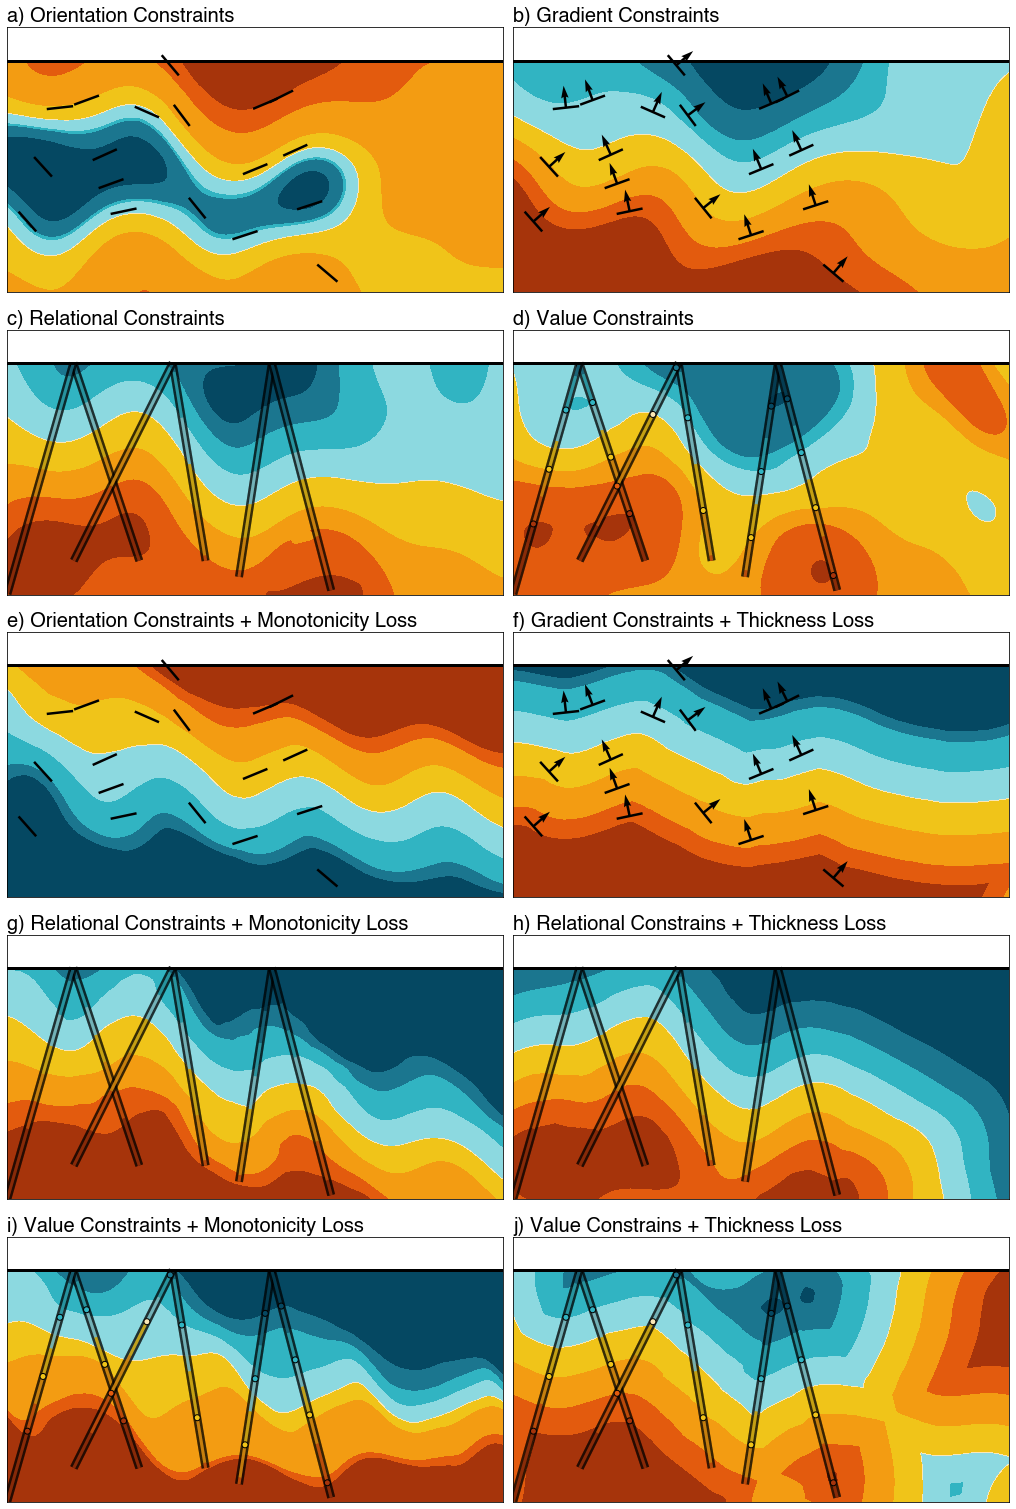

In [22]:
# Complete Figure
fig, ax = plt.subplots(5, 2, figsize=(14, 21), sharex=True, sharey=True, layout="constrained")
all_names = ['Orientation Constraints', 'Gradient Constraints',
             'Relational Constraints', 'Value Constraints',
             'Orientation Constraints + Monotonicity Loss', 'Gradient Constraints + Thickness Loss',
             'Relational Constraints + Monotonicity Loss', 'Relational Constrains + Thickness Loss',
             'Value Constraints + Monotonicity Loss', 'Value Constrains + Thickness Loss',
            ]
labels_ = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]

# Just load the models if you don't want to run the training!
all_models = joblib.load("./Models/folded_stratigraphy_models_22_09_25.pkl")
all_H = np.hstack([np.array(H_), np.array(global_H_)])

for i in range(10):
    # Retrieve model
    M = all_models[i]
    H = all_H[i].copy()
    
    # Predict
    pred = M.predict(gxy)
    classes, _ = M.classify(gxy)

    # Plotting
    # Plot the drillholes
    if (i > 1 and i < 4) or (i > 5):
        for hole in holes:
            plotDrill(hole, ax=ax.ravel()[i], lw=3, ticksize=0, vmn=vmn, vmx=vmx, cmap=curlew_cmap)

    # Plot the stratigraphy
    plot2D(classes[:, 0], grid_obj, ax=ax.ravel()[i], levels=False, C=None, cmap=curlew_cmap, alpha=1)
    # Plot the constraints
    plotConstraints(ax.ravel()[i], C, H, ll=1.2, lw=0.005, scale=0.015, ac="k", vmn=None, vmx=np.max(classes), cmap=curlew_cmap)
    # Title
    ax.ravel()[i].set_title(labels_[i] + ") " + all_names[i], loc="left")
    # Surface line
    ax.ravel()[i].axhline(700, c="k", lw=3, zorder=9)
    
# Remove ticks to make plot pretty!
_ = [ax_.set_xticks([]) for ax_ in ax.ravel()]
_ = [ax_.set_yticks([]) for ax_ in ax.ravel()]
ax.ravel()[0].set_ylim([0, dims[1]+100])

# Save the figure
plt.savefig("./Figures/Local_And_Global_Losses.png", dpi=300)
plt.show()

### Length scales in `curlew`

The length scale parameter $\ell_s$ allows us to seed the model with known wavelengths of the features we expect to see.

In [23]:
# Let us test these global losses with a model
# Number of epochs
nepochs = 2000

# Define hyperparameter sets for testing
# Orientation + Mono
H_l = curlew.HSet()
H_l = H_l.zero(iq_loss="1", grad_loss="1", mono_loss="10")

# Model List
ls_model_list = []

In [24]:
# Fit!
scales = [[50, 500], [150, 500], [150, 1000], [500, 2000]]
names = ['L = ' + str(scale) for scale in scales]

for i in range(len(scales)):
    print("Fitting %s"%names[i])
    # Get the HSet
    H = H_l

    # Initialise the interpolator
    nf0 = strati('basement', # name for this scalar field
                 C, # constraints for this field
                 H, # interpolator hyperparameters
                 base=-np.inf, # basal surface (important for unconformities)
                 input_dim=2, # field input coordinate dimensions (2D in our case)
                 hidden_layers=[512,], # hidden layers in the multi-layer perceptron that parameterises our field
                 rff_features=128, # number of random sin and cos features to create for each scale 
                 length_scales=scales[i], # the length scales in our model
                 seed=404 # RNG seed
                )

    # Define Isosurfaces (also using contact points)
    for hole in holes:
        for p,n in zip(hole['contacts']['pos'], hole['contacts']['classID']):
            nf0.isosurfaces[ hole['className'][n] ] = nf0.isosurfaces.get(hole['className'][n],[]) + [p]    
        
    # Initialise a GeoModel object
    M = GeoModel([nf0]) 

    # Fit the model
    _ = M.prefit(epochs=nepochs)
            
    # Store the model
    ls_model_list.append(M)

Fitting L = [50, 500]


basement: 806/2000|, grad_loss=0.0219, mono_loss=0.268, iq_loss=0.0823 


Fitting L = [150, 500]


basement: 1604/2000|, grad_loss=0.0223, mono_loss=0.778, iq_loss=0.0378  


Fitting L = [150, 1000]


basement: 1064/2000|, grad_loss=0.0282, mono_loss=0.295, iq_loss=0.00249


Fitting L = [500, 2000]


basement: 293/2000|, grad_loss=0.145, mono_loss=3.01, iq_loss=15.7     


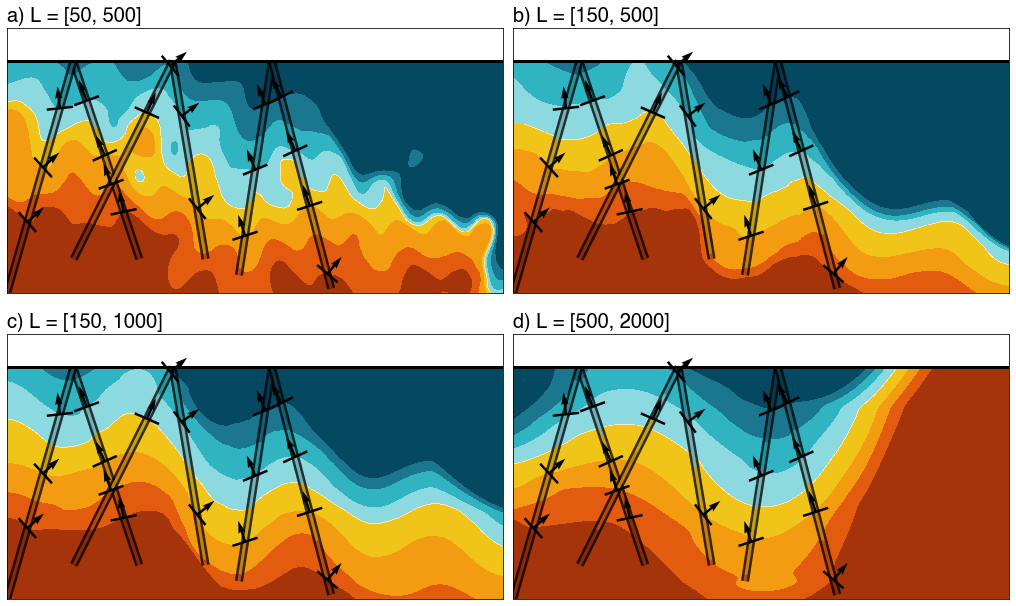

In [25]:
# Complete Figure
fig, ax = plt.subplots(2, 2, figsize=(14, 8.5), sharex=True, sharey=True, layout="constrained")
labels_ = ["a", "b", "c", "d"]

for i in range(len(scales)):
    # Retrieve model
    M = ls_model_list[i]
    H = H_l
    
    # Predict
    pred = M.predict(gxy)
    classes, _ = M.classify(gxy)

    # Plotting
    # Plot the drillholes
    for hole in holes:
        plotDrill(hole, ax=ax.ravel()[i], lw=3, ticksize=0, vmn=vmn, vmx=vmx, cmap=curlew_cmap)

    # Plot the stratigraphy
    plot2D(classes[:, 0], grid_obj, ax=ax.ravel()[i], levels=False, C=None, cmap=curlew_cmap, alpha=1)
    # Plot the constraints
    plotConstraints(ax.ravel()[i], C, H, ll=1.2, lw=0.005, scale=0.015, ac="k", vmn=None, vmx=np.max(classes), cmap=curlew_cmap)
    # Title
    ax.ravel()[i].set_title(labels_[i] + ") " + names[i], loc="left")
    # Surface line
    ax.ravel()[i].axhline(700, c="k", lw=3, zorder=9)
    
# Remove ticks to make plot pretty!
_ = [ax_.set_xticks([]) for ax_ in ax.ravel()]
_ = [ax_.set_yticks([]) for ax_ in ax.ravel()]
ax.ravel()[0].set_ylim([0, dims[1]+100])

# Save the figure
plt.savefig("./Figures/Length_Scales.png", dpi=300)
plt.show()